In [3]:
import pandas as pd

Trying to separate the video searches to their appropriate companies

In [10]:
df1 = pd.read_excel('youtube_data_latest.xlsx', sheet_name=0)
df2 = pd.read_excel('youtube_data_latest.xlsx', sheet_name=1)

Associating the comments and videos to their appropriate companies

In [6]:
company_keywords = {
    'Abarth': ['Abarth', 'abarth', 'ABARTH'],
    'Fiat': ['Fiat', 'fiat', 'FIAT'],
    'Mini': ['Mini', 'mini', 'MINI'],
    'Peugeot': ['Peugeot', 'peugeot', 'PEUGEOT'],
    'Volkswagen': ['Volkswagen', 'volkswagen', 'VW', 'vw', 'Vw'],
    'Tesla': ['Tesla', 'tesla', 'TESLA']
}

def assign_company(row):
    for company, keywords in company_keywords.items():
        if any(keyword in str(row['Post_Title']) or keyword in str(row['Post_Content']) for keyword in keywords):
            return company
    return 'Unknown'

df1['Company'] = df1.apply(assign_company, axis=1)

In [9]:
df1[df1['Company'] == 'Unknown'].head()

,Post_id,Post_Title,Author,Date,Post_Content,Comment_Number,Net_Like,Views,Company
53,GI9pkcFJXV4,All about the Taurozzi Pendulum Engine 🧠 and w...,Repairman22,2023-01-21T14:00:08Z,In this video we analyze the Taurozzi pendulum...,2371,31430,1540034,Unknown
54,9lse1SfDq7M,Engine lubrication system / How does it work? ...,CARinfo3d (En),2022-12-07T13:47:38Z,The internal combustion engine contains numero...,66,4153,165024,Unknown
60,W94iksaQwUo,How Ignition System Works,Automotive System,2012-08-13T12:55:59Z,Know the basic working of an automobile igniti...,949,32122,4814980,Unknown
61,90uUdwJBEu4,Learn about every Engine Layout in just one vi...,The Engineers Post,2023-01-02T13:16:16Z,Straight/Inline engine:\nThe straight or inlin...,204,7424,380541,Unknown
64,x70VqMrXrbs,Car Engine Parts & Their Functions Explained i...,The Engineers Post,2021-04-17T11:39:00Z,List of Car Engine Parts | TheEngineersPost\n\...,793,109477,4054744,Unknown


Combining df2 to locate comments with Unknown company, labeled in df1

In [5]:
#Mapping to df2 to remove unwanted video comments
merged_df2 = df2.merge(df1[['Post_id', 'Company']], on='Post_id', how='left')

In [6]:
#Checking the length of the Unknown in df1 and df2
print(df1[df1['Company'] == 'Unknown']['Comment_Number'].sum())
print(len(merged_df2[merged_df2['Company']=='Unknown']))

44820
33630


In [12]:
#Dropping the NaN values
merged_df1 = df1[df1['Company'] != 'Unknown']
merged_df2 = merged_df2.dropna(subset=['Comment_Content'])

**Dealing with different languages**

In [14]:
#Library is used for detecting the language
from langdetect import detect

#Function used for running the comments through to detect the language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

#Creates a new column 'language' in merged_df2 to detect the language in the comment
merged_df2['language'] = merged_df2['Comment_Content'].apply(detect_language)

In [34]:
merged_df2.head()

,Unique_id,Post_id,Author,Date,Comment_Content,Reply_id,Company,language
0,UgwxZe_9rq6Divz2B6V4AaABAg,eQlcDSnItRk,Tomas Juricek,2023-05-27T08:14:43Z,Not more car,0,Abarth,ro
1,UgyaJ0l-wY032jA6YsR4AaABAg,eQlcDSnItRk,Todd Turner,2023-05-21T12:25:06Z,If Hydrocarbons came from dinosaurs how many o...,0,Abarth,en
2,Ugxp60x3am7lNpJjYt94AaABAg,eQlcDSnItRk,PoltergeistWorks,2023-05-20T19:08:31Z,"Less power, less range, fake noise and twice t...",0,Abarth,en
3,UgxfZcCbo05HhzRi1Ht4AaABAg,eQlcDSnItRk,Spooligan,2023-05-17T10:54:08Z,TF?!? 96mph? A prius does 0 to 60 faster than ...,0,Abarth,en
4,UgxZboo7_6pqKXGUAt94AaABAg,eQlcDSnItRk,Miguel Afonso,2023-05-16T22:44:14Z,"Even slower that a 595 I reckon, and you can h...",0,Abarth,en


In [1]:
#Saving the file
#merged_df1.to_csv('merged_df1___.csv', index=False)
#merged_df2.to_csv('merged_df2___.csv', index=False)

LOADING THE LATEST FILES

In [4]:
#Loading the file
merged_df1 = pd.read_csv('merged_df1.csv')
merged_df2 = pd.read_csv('merged_df2.csv')

In [5]:
print(len(merged_df1[merged_df1['Company']=='Unknown']))

0


In [6]:
len(merged_df2)

181877

Dropping unknown, duplicates and non English comments

In [159]:
#Dropping the unknown company comments, a lot unrelated
merged_df1 = merged_df1[merged_df1['Company'] != 'Unknown']
merged_df2 = merged_df2[merged_df2['Company'] != 'Unknown']

In [160]:
#Seaparating the english and non-english comments
english_comments = merged_df2[merged_df2['language'] == 'en']
non_english_comments = merged_df2[merged_df2['language'] != 'en']

# Removing the duplicated words
english_comments = english_comments.drop_duplicates()
non_english_comments = non_english_comments.drop_duplicates()

In [161]:
#For all the data within merged_df2
print(len(english_comments) + len(non_english_comments))
print(len(english_comments))
print(len(non_english_comments))

126428
104147
22281


**After separating the languages, here comes the NLP pre-processing stage**

In [162]:
import spacy
import string

# Load Spacy model
nlp = spacy.load('en_core_web_sm')

In [163]:
def clean_text(text):
    # Parse the text with SpaCy. This runs the entire pipeline.
    doc = nlp(text)
    
    # 'd' contains the difference between set of all characters and the set of punctuations
    d = set(string.printable) - set(string.punctuation)

    # create a new list to hold the modified tokens
    new_tokens = []

    i = 0
    while i < len(doc):
        # If the current token is 'not' and the next token exists
        if doc[i].lemma_ == 'not' and i < len(doc) - 1:
            # append the next token text preceded by 'not_'
            new_tokens.append('not_' + doc[i+1].text)
            # increment i by 2 to skip the next token
            i += 2
        else:
            # otherwise, append the current token lemma
            new_tokens.append(doc[i].lemma_)
            # increment i by 1 to move to the next token
            i += 1

    # Filter tokens that are stop words or punctuation symbols and that are not in the printable set of characters
    tokens = [token for token in new_tokens if not nlp.vocab[token].is_stop and not nlp.vocab[token].is_punct and all([ch in d for ch in token])]
    
    # Lowercase, lemmatize, and remove non-alphabetic characters
    cleaned_tokens = [token.lower() for token in tokens if token.isalpha()]

    # Additional stop words list
    additional_stopwords = ['car', 'like', 'go', 'vehicle', 'to', 'abarth', 'andy', 'need', 'want', 'think', 'yeah', 'way', 'lol', 'fiat',
                            'vw', 'volkswagen', 'peugeot','mini', 'tesla', 'honda', 'bmw', 'chrysler', 'toyota']
    cleaned_tokens = [token for token in cleaned_tokens if token not in additional_stopwords]
    
    
    # Join cleaned tokens back into a string
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

In [140]:
def clean_text(text):
    # Parse the text with SpaCy. This runs the entire pipeline.
    doc = nlp(text)
    
    # 'd' contains the difference between set of all characters and the set of punctuations
    d = set(string.printable) - set(string.punctuation)

    # Additional stop words list and in POS tag
    additional_stopwords = ['car', 'like', 'go', 'vehicle', 'to', 'abarth', 'andy', 'need', 'want', 'think', 'yeah', 'way', 'lol', 'fiat',
                            'vw', 'volkswagen', 'peugeot','mini', 'tesla', 'honda', 'bmw', 'chrysler', 'toyota']
    tags_to_remove = ['CONJ', 'ADP', 'PRON', 'DET']  # Universal POS tags, you may want to modify this to match SpaCy's descriptions
    
    # Process tokens
    cleaned_tokens = []
    for token in doc:
        if (token.is_alpha and 
            all([ch in d for ch in token.text]) and 
            token.lemma_.lower() not in additional_stopwords and 
            token.pos_ not in tags_to_remove):
            cleaned_tokens.append(token.lemma_.lower())

    # Join cleaned tokens back into a string
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

In [164]:
# Apply preprocessing to each comment
english_comments['Comment_Content'] = english_comments['Comment_Content'].apply(clean_text)

In [165]:
english_comments[english_comments['Company'] == 'Mini'].head()

,Unique_id,Post_id,Author,Date,Comment_Content,Reply_id,Company,language
29449,Ugws7xy3YoMWvdi_hpZ4AaABAg,03p2if6xqMo,Ryan Shaw,2023-05-22T16:11:11Z,check fe battery metal,0,Mini,en
29450,Ugwkt-eaB68rIgReNfx4AaABAg,03p2if6xqMo,Brian,2023-06-02T16:03:25Z,got feed tax credit nj ev rebate dealer deal,0,Mini,en
29451,Ugy4z3FCYc1bpbOdJXR4AaABAg,03p2if6xqMo,Brian,2023-06-02T15:56:43Z,wheel,0,Mini,en
29452,UgzzFJ9IGyDvUQOddiJ4AaABAg,03p2if6xqMo,Brian,2023-06-02T15:54:57Z,bolt dead long live bolt,0,Mini,en
29453,UgzAWKTD6OMNfvFPcIt4AaABAg,03p2if6xqMo,Brian,2023-06-02T15:53:33Z,nissa leaf toad,0,Mini,en


In [166]:
#Checking how many companies are there
unique_companies = english_comments['Company'].unique()
for company in unique_companies:
    print(company)

Abarth
Fiat
Tesla
Mini
Volkswagen
Peugeot


Making individual dataframes for each companies

In [167]:
#Separating the dataframe to their companies
Abarth = english_comments[english_comments['Company']=='Abarth']
Fiat= english_comments[english_comments['Company']=='Fiat']
Tesla= english_comments[english_comments['Company']=='Tesla']
Mini= english_comments[english_comments['Company']=='Mini']
Volkswagen= english_comments[english_comments['Company']=='Volkswagen']
Peugeot= english_comments[english_comments['Company']=='Peugeot']

In [168]:
#Making all these comments to list
Abarth_comments = Abarth['Comment_Content'].tolist()
Fiat_comments = Fiat['Comment_Content'].tolist()
Tesla_comments = Tesla['Comment_Content'].tolist()
Mini_comments = Mini['Comment_Content'].tolist()
Volkswagen_comments = Volkswagen['Comment_Content'].tolist()
Peugeot_comments = Peugeot['Comment_Content'].tolist()

Constructing the ngrams

In [169]:
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Tokenize the comments
Abarth_comments = list(sent_to_words(Abarth['Comment_Content']))
Fiat_comments = list(sent_to_words(Fiat['Comment_Content']))
Tesla_comments = list(sent_to_words(Tesla['Comment_Content']))
Mini_comments = list(sent_to_words(Mini['Comment_Content']))
Volkswagen_comments = list(sent_to_words(Volkswagen['Comment_Content']))
Peugeot_comments = list(sent_to_words(Peugeot['Comment_Content']))

In [170]:
from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess

In [171]:
# Train the bigram and trigram models
bigram = Phrases(Abarth_comments + Fiat_comments + Tesla_comments + Mini_comments + Volkswagen_comments + Peugeot_comments, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = Phrases(bigram[Abarth_comments + Fiat_comments + Tesla_comments + Mini_comments + Volkswagen_comments + Peugeot_comments], threshold=10)  

In [172]:
# Get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [173]:
def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [174]:
# Form Bigrams
Abarth_comments_bigrams = make_bigrams(Abarth_comments, bigram_mod)
Fiat_comments_bigrams = make_bigrams(Fiat_comments, bigram_mod)
Tesla_comments_bigrams = make_bigrams(Tesla_comments, bigram_mod)
Mini_comments_bigrams = make_bigrams(Mini_comments, bigram_mod)
Volkswagen_comments_bigrams = make_bigrams(Volkswagen_comments, bigram_mod)
Peugeot_comments_bigrams = make_bigrams(Peugeot_comments, bigram_mod)

# Form Trigrams
Abarth_comments_trigrams = make_trigrams(Abarth_comments, trigram_mod)
Fiat_comments_trigrams = make_trigrams(Fiat_comments, trigram_mod)
Tesla_comments_trigrams = make_trigrams(Tesla_comments, trigram_mod)
Mini_comments_trigrams = make_trigrams(Mini_comments, trigram_mod)
Volkswagen_comments_trigrams = make_trigrams(Volkswagen_comments, trigram_mod)
Peugeot_comments_trigrams = make_trigrams(Peugeot_comments, trigram_mod)

In [175]:
Abarth_comments_bigrams

[['hydrocarbon', 'come', 'dinosaur', 'titan'],
 ['power', 'range', 'fake_noise', 'twice', 'price', 'petrol', 'sorry'],
 ['tf',
  'mph',
  'prius',
  'fast',
  'fast',
  'mph',
  'fail',
  'usa',
  'mph',
  'sad',
  'day',
  'italians'],
 ['slow', 'reckon', 'manual', 'fake_sound', 'lack', 'word', 'appalling'],
 ['modify', 'big', 'battery_pack', 'possible'],
 ['love',
  'canada',
  'sadly',
  'canada',
  'stop',
  'bring',
  'strong',
  'day',
  'come',
  'lot'],
 ['electric',
  'waaaaaaaay',
  'expensive',
  'money',
  'review',
  'rating',
  'afford',
  'huge',
  'waste_time',
  'review',
  'rate',
  'futuristic',
  'prototype',
  'decade_ago',
  'build',
  'basically',
  'fantasy',
  'consideration'],
 ['spec', 'rubbish'],
 ['fake_exhaust',
  'sound',
  'electric',
  'world',
  'live',
  'afraid',
  'ask',
  'society',
  'stupid'],
 ['rubbish', 'try'],
 ['noise',
  'outside',
  'weird',
  'overall',
  'look',
  'great',
  'consider',
  'buy',
  'release',
  'poland',
  'great',
  'loo

Making dictionary to map integer ids and the words

In [176]:
from gensim import corpora, models

def create_dict_corpus(texts):
    # Create Dictionary
    id2word = corpora.Dictionary(texts)
    
    # Create Corpus
    texts = texts
    
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return id2word, corpus

In [177]:
#This utilises the trigrams
Abarth_id2word, Abarth_corpus = create_dict_corpus(Abarth_comments_trigrams)
Fiat_id2word, Fiat_corpus = create_dict_corpus(Fiat_comments_trigrams)
Tesla_id2word, Tesla_corpus = create_dict_corpus(Tesla_comments_trigrams)
Mini_id2word, Mini_corpus = create_dict_corpus(Mini_comments_trigrams)
Volkswagen_id2word, Volkswagen_corpus = create_dict_corpus(Volkswagen_comments_trigrams)
Peugeot_id2word, Peugeot_corpus = create_dict_corpus(Peugeot_comments_trigrams)

Creating the LDA model for each of the company

In [178]:
import gensim
from gensim.models.coherencemodel import CoherenceModel

def create_lda_models_with_coherence(id2word, corpus, texts, min_topics=5, max_topics=15):
    coherence_values = []
    for num_topics in range(min_topics, max_topics):
        print('Round:', num_topics)
        
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=num_topics,
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
        
        cm = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append((num_topics, cm.get_coherence()))

    return lda_model, coherence_values


In [222]:
from gensim.models.coherencemodel import CoherenceModel

def create_lda_models_with_coherence(id2word, corpus, texts, min_topics=5, max_topics=15):
    max_coherence = 0
    best_lda_model = None
    coherence_values = []

    for num_topics in range(min_topics, max_topics):
        print('Round:', num_topics)
        
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=num_topics,
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
        
        cm = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append((num_topics, cm.get_coherence()))
        coherence = cm.get_coherence()

        if coherence > max_coherence:
            max_coherence = coherence
            best_lda_model = lda_model

    return best_lda_model, coherence_values, max_coherence

In [223]:
Abarth_lda_model, Abarth_C, Abarth_max = create_lda_models_with_coherence(Abarth_id2word, Abarth_corpus, Abarth_comments_trigrams)
Fiat_lda_model, Fiat_C, Fiat_max = create_lda_models_with_coherence(Fiat_id2word, Fiat_corpus, Fiat_comments_trigrams)
Tesla_lda_model, Tesla_C, Tesla_max = create_lda_models_with_coherence(Tesla_id2word, Tesla_corpus, Tesla_comments_trigrams)
Mini_lda_model, Mini_C, Mini_max = create_lda_models_with_coherence(Mini_id2word, Mini_corpus, Mini_comments_trigrams)
Volkswagen_lda_model, Volk_C, Volk_max = create_lda_models_with_coherence(Volkswagen_id2word, Volkswagen_corpus, Volkswagen_comments_trigrams)
Peugeot_lda_model, Peugeot_C, Peugeot_max = create_lda_models_with_coherence(Peugeot_id2word, Peugeot_corpus, Peugeot_comments_trigrams)

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14


In [225]:
Abarth_topics = Abarth_lda_model.print_topics(num_words=6)
for topic in Abarth_topics:
    print(topic)

(0, '0.092*"people" + 0.079*"know" + 0.034*"motor" + 0.031*"chrysler" + 0.025*"interesting" + 0.016*"original"')
(1, '0.046*"come" + 0.038*"small" + 0.032*"battery" + 0.026*"video" + 0.025*"nice" + 0.025*"year"')
(2, '0.096*"love" + 0.034*"design" + 0.031*"mile" + 0.020*"light" + 0.019*"maybe" + 0.017*"technology"')
(3, '0.042*"start" + 0.041*"fake" + 0.039*"hate" + 0.033*"probably" + 0.030*"change" + 0.027*"point"')
(4, '0.092*"range" + 0.060*"price" + 0.029*"cheap" + 0.022*"sorry" + 0.018*"door" + 0.016*"different"')
(5, '0.055*"cool" + 0.054*"bad" + 0.036*"usa" + 0.027*"km" + 0.024*"honestly" + 0.022*"amazing"')
(6, '0.057*"sound" + 0.050*"ev" + 0.039*"electric" + 0.037*"engine" + 0.028*"drive" + 0.027*"good"')
(7, '0.126*"look" + 0.059*"great" + 0.048*"buy" + 0.038*"hope" + 0.033*"city" + 0.021*"try"')
(8, '0.043*"system" + 0.036*"owner" + 0.030*"find" + 0.030*"company" + 0.028*"miss" + 0.026*"smart"')
(9, '0.036*"usb" + 0.035*"pretty" + 0.030*"size" + 0.020*"horrible" + 0.019*"all

In [226]:
Mini_topics = Mini_lda_model.print_topics(num_words=6)
for topic in Mini_topics:
    print(topic)

(0, '0.047*"design" + 0.030*"love" + 0.026*"range" + 0.024*"new" + 0.024*"buy" + 0.022*"small"')
(1, '0.050*"battery" + 0.045*"ev" + 0.031*"good" + 0.026*"motor" + 0.023*"great" + 0.020*"thing"')
(2, '0.132*"look" + 0.028*"sell" + 0.026*"year" + 0.026*"come" + 0.023*"big" + 0.020*"interior"')
(3, '0.026*"start" + 0.020*"right" + 0.014*"little" + 0.014*"maybe" + 0.012*"ugly" + 0.011*"sound"')
(4, '0.067*"price" + 0.042*"people" + 0.034*"cool" + 0.029*"time" + 0.023*"know" + 0.015*"long"')
(5, '0.056*"electric" + 0.030*"power" + 0.024*"expensive" + 0.018*"polo" + 0.015*"day" + 0.012*"interesting"')


In [217]:
Tesla_topics = Tesla_lda_model.print_topics(num_words=6)
for topic in Tesla_topics:
    print(topic)

(0, '0.106*"hydrogen" + 0.058*"ev" + 0.043*"toyota" + 0.039*"engine" + 0.034*"use" + 0.032*"electric"')
(1, '0.034*"buy" + 0.030*"future" + 0.028*"time" + 0.023*"video" + 0.019*"love" + 0.017*"great"')
(2, '0.024*"water" + 0.024*"technology" + 0.022*"charge" + 0.021*"cost" + 0.020*"year" + 0.017*"world"')
(3, '0.027*"ice" + 0.025*"power" + 0.022*"drive" + 0.021*"problem" + 0.020*"run" + 0.020*"look"')
(4, '0.051*"good" + 0.037*"gas" + 0.021*"sound" + 0.019*"efficient" + 0.017*"right" + 0.016*"clean"')


In [218]:
Mini_topics = Mini_lda_model.print_topics(num_words=6)
for topic in Mini_topics:
    print(topic)

(0, '0.047*"design" + 0.030*"love" + 0.026*"range" + 0.024*"new" + 0.024*"buy" + 0.022*"small"')
(1, '0.050*"battery" + 0.045*"ev" + 0.031*"good" + 0.026*"motor" + 0.023*"great" + 0.020*"thing"')
(2, '0.132*"look" + 0.028*"sell" + 0.026*"year" + 0.026*"come" + 0.023*"big" + 0.020*"interior"')
(3, '0.026*"start" + 0.020*"right" + 0.014*"little" + 0.014*"maybe" + 0.012*"ugly" + 0.011*"sound"')
(4, '0.067*"price" + 0.042*"people" + 0.034*"cool" + 0.029*"time" + 0.023*"know" + 0.015*"long"')
(5, '0.056*"electric" + 0.030*"power" + 0.024*"expensive" + 0.018*"polo" + 0.015*"day" + 0.012*"interesting"')


In [219]:
Volk_topics = Volkswagen_lda_model.print_topics(num_words=6)
for topic in Volk_topics:
    print(topic)

(0, '0.052*"electric" + 0.029*"buy" + 0.026*"year" + 0.024*"new" + 0.022*"thing" + 0.017*"van"')
(1, '0.046*"look" + 0.037*"range" + 0.029*"drive" + 0.024*"good" + 0.020*"love" + 0.016*"design"')
(2, '0.028*"charge" + 0.017*"problem" + 0.014*"sound" + 0.014*"bring" + 0.013*"manufacturer" + 0.013*"future"')
(3, '0.055*"ev" + 0.035*"battery" + 0.023*"come" + 0.020*"people" + 0.018*"mile" + 0.017*"know"')
(4, '0.037*"use" + 0.026*"time" + 0.017*"screen" + 0.014*"bad" + 0.013*"right" + 0.012*"yes"')


In [220]:
Peugeot_topics = Peugeot_lda_model.print_topics(num_words=6)
for topic in Peugeot_topics:
    print(topic)

(0, '0.146*"good" + 0.028*"lot" + 0.026*"seat" + 0.026*"day" + 0.022*"problem" + 0.019*"diesel"')
(1, '0.186*"look" + 0.080*"love" + 0.066*"mat" + 0.033*"headlight" + 0.017*"awesome" + 0.016*"possible"')
(2, '0.060*"drive" + 0.057*"video" + 0.046*"use" + 0.025*"wait" + 0.017*"actually" + 0.016*"order"')
(3, '0.044*"buy" + 0.030*"people" + 0.027*"suv" + 0.022*"electric" + 0.020*"small" + 0.019*"time"')
(4, '0.080*"great" + 0.045*"ev" + 0.041*"bad" + 0.032*"vs" + 0.017*"bring" + 0.016*"market"')
(5, '0.043*"thank" + 0.034*"cool" + 0.024*"guy" + 0.023*"amazing" + 0.022*"beautiful" + 0.017*"follow"')
(6, '0.055*"model" + 0.026*"start" + 0.023*"stop" + 0.020*"compare" + 0.018*"home" + 0.018*"watch"')
(7, '0.053*"matt" + 0.042*"french" + 0.033*"interior" + 0.029*"year" + 0.027*"engine" + 0.023*"version"')
(8, '0.097*"review" + 0.066*"new" + 0.060*"design" + 0.038*"nice" + 0.030*"carwow" + 0.027*"come"')


Visualising the coherence scores

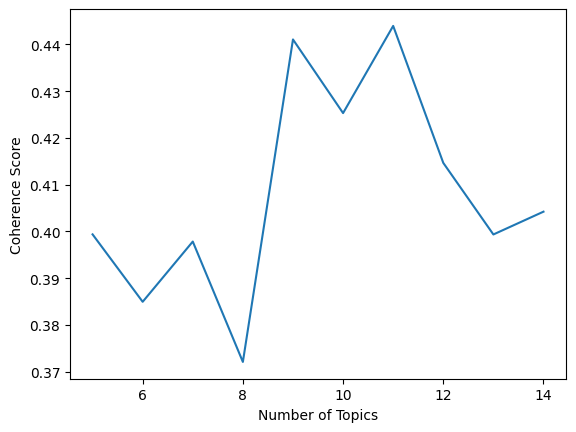

In [227]:
import matplotlib.pyplot as plt

def plot_coherence(coherence_values):
    topics, coherences = zip(*coherence_values)
    plt.plot(topics, coherences)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.show()

plot_coherence(Abarth_C)

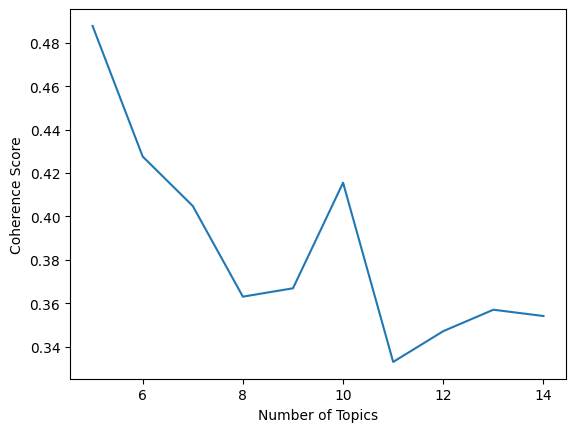

In [228]:
plot_coherence(Fiat_C)

Pyldavis Visualisation